### **跟隨大戶的交易策略**
策略出處：

一般來說，三大法人、關鍵內部人或是其他千張大戶相較於散戶會擁有較多的資訊，因此較有可能挑選出潛力股或是避開地雷股。金管會為了降低資訊不對等，便要求公司或券商公布每日買賣資料，使得投資人能藉由觀察大戶們的買賣動向去分析股價的未來走勢，而這就是所謂的籌碼分析。

交易邏輯：

* 買入訊號 : 當三大法人合計買超，且三大法人合計持股率低於近五日平均時，代表後續或許有一波漲勢，故給予買入訊號

* 賣出訊號 : 當三大法人合計賣超，且三大法人合計持股率高於近五日平均時，代表法人可能準備出貨，故給予賣出訊號


### Tejapi、Zipline、Pyfolio套件引入

In [1]:
import tejapi
import os
os.environ['TEJAPI_KEY'] = "your key" 
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from zipline.pipeline import Pipeline
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.factors import CustomFactor, AverageDollarVolume, SimpleMovingAverage, Returns
from zipline.master import get_prices, getToolData, tejquant, run_pipeline
from TejToolAPI.TejToolAPI import get_history_data

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

import matplotlib.pyplot as plt
import seaborn as sns

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         date_rules,
                         time_rules,
                         record,
                         schedule_function,
                         commission,
                         slippage,
                         set_slippage,
                         set_commission,
                         set_cancel_policy,
                         get_open_orders,
                         get_datetime,
                         cancel_order,
                         order_target,
                         order_target_value,
                         order_target_percent,
                         set_benchmark,
                         symbol)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet, tejquant
from zipline.pipeline.domain import TW_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import time
from collections import defaultdict
from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                          get_Benchmark_Return,
                                          )

In [3]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import show_perf_stats

sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

### TejToolAPI－三大法人持股比率&每日買賣超資料載入

* 股票池

In [4]:
tickers = '1101 1102 1216 1301 1303 1326 1402 1476 1590 1605 1722 1802 2002 2105 2201 2207 \
2227 2301 2303 2308 2311 2317 2324 2325 2327 2330 2347 2353 2354 2357 2379 2382 2395 2408 \
2409 2412 2448 2454 2474 2492 2498 2603 2609 2615 2618 2633 2801 2823 2880 2881 2882 2883 \
2884 2885 2886 2887 2888 2890 2891 2892 2912 3008 3009 3034 3037 3045 3231 3474 3481 3673 \
3697 3711 4904 4938 5854 5871 5876 5880 6239 6415 6505 6669 6770 8046 8454 9904 9910'

* Ingest前述的公司代碼進bundle

In [5]:
os.environ['ticker'] = tickers
os.environ['mdate'] = "20150101 20230816"
!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 220/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 24236033/9223372036854775807 (0.0%)


[2024-02-07 02:43:40.974832] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-02-07 02:43:59.886439] INFO: zipline.data.bundles.core: Ingest tquant successfully.


* 載入所需的三大法人持股比例與每日合計買賣超

In [6]:
from zipline.data import bundles
bundle_name = 'tquant'
bundle = bundles.load(bundle_name)

sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbols = [i.symbol for i in assets]

df = get_history_data(ticker=symbols, columns=['qfii_pct', 'fd_pct', 'dlr_pct', 'tot_ex'], start='2020-01-01', end='2023-08-15')

df = df.sort_values(['coid', 'mdate'])

df = df.assign(Total_Pct=df.Fund_Stock_Holding_Pct + df.Qfii_Stock_Holding_Pct + df.Dealer_Stock_Holding_Pct)

Currently used TEJ API key call quota 224/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 24331256/9223372036854775807 (0.0%)


* 將三大法人資料轉成Zipline所需格式

In [7]:
def Custom_loader(df, bundle):

    df['coid'] = df['coid'].astype(str)
        
    column = df.columns[~df.columns.isin(['coid', 'mdate'])].tolist()

    df1 = df.set_index(['coid', 'mdate'])
    symbols = df1.index.get_level_values(0).unique().astype(str).tolist()  

    assets = bundle.asset_finder.lookup_symbols(symbols, as_of_date=None)
    assets_map = {i.symbol: i for i in assets}

    baseline_data = {}

    for i in column:
        target = df1.unstack('coid')[i]
        target.columns = target.columns.map(assets_map)
        target = target.tz_localize('UTC').tz_convert('UTC')
        baseline_data.update({i: target})

    return baseline_data

In [8]:
baseline_data = Custom_loader(df, bundle)

baseline_data.keys()

dict_keys(['Qfii_Stock_Holding_Pct', 'Fund_Stock_Holding_Pct', 'Dealer_Stock_Holding_Pct', 'Total_Diff_Vol', 'Total_Pct'])

In [9]:
class CustomDataset(DataSet):
    total_vol = Column(dtype=float)
    total_pct = Column(dtype=float)

    domain = TW_EQUITIES     
    
transform_data = {
    CustomDataset.total_vol: DataFrameLoader(CustomDataset.total_vol, baseline_data['Total_Diff_Vol']),
    CustomDataset.total_pct: DataFrameLoader(CustomDataset.total_pct, baseline_data['Total_Pct']),
                  }

transform_data

{CustomDataset<TW>.total_vol::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x214e429d950>,
 CustomDataset<TW>.total_pct::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x214e3aa0f10>}

### Pipeline－進出場指標計算

In [10]:
def make_pipeline(ma_days):

    vol = CustomDataset.total_vol.latest
    pct = CustomDataset.total_pct.latest

    pct_ma = SimpleMovingAverage(inputs=[CustomDataset.total_pct], window_length=ma_days)

    longs = (pct < pct_ma) & (vol > 0)
    shorts = (pct > pct_ma) & (vol < 0)

    pipe = Pipeline(
        columns={
            'Total_volume_diff': vol,
            'Total_pct': pct,
            'Total_pct_ma':pct_ma,
            'longs': longs,
            'shorts': shorts
        },
    )
    return pipe

In [11]:
start_dt = pd.Timestamp('2020-01-01', tz='utc')
end_dt = pd.Timestamp('2023-08-15', tz='utc')

from zipline.pipeline.loaders import EquityPricingLoader

pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader, bundle.adjustment_reader)
def choose_loader(column):
    if column in TWEquityPricing.columns:
        return pricing_loader
    return transform_data[column]

from zipline.pipeline.engine import SimplePipelineEngine

engine = SimplePipelineEngine(get_loader=choose_loader,
                              asset_finder=bundle.asset_finder,
                              )

data = engine.run_pipeline(make_pipeline(5), start_dt, end_dt)
data

Total_volume_diff  Total_pct  Total_pct_ma  longs  shorts
2020-01-02 00:00:00+00:00 Equity(0 [1101])             -1030.0      31.40        31.400  False   False
                          Equity(1 [1102])              -624.0      30.52        30.520  False   False
                          Equity(2 [1216])             -2401.0      53.74        53.740  False   False
                          Equity(3 [1301])             -1310.0      39.08        39.080  False   False
                          Equity(4 [1303])               -80.0      31.02        31.020  False   False
...                                                        ...        ...           ...    ...     ...
2023-08-15 00:00:00+00:00 Equity(79 [6770])            -5435.0      15.13        15.132  False   False
                          Equity(80 [8046])              809.0      13.06        12.932  False   False
                          Equity(81 [8454])             -218.0      24.02        24.164  False   False
                          Equity(82 [9904])             -776.0      47.75        47.782  False   False
                          Equity(83 [9910])             -488.0      17.69        17.750  False   False

[69705 rows x 5 columns]

### Zipline－交易策略回測

* 設定固定滑價成本和交易手續費各為0.2%
  
* 個股進場邏輯：每天買進股票池中符合條件之個股，使用當前投組可動用現金的5%

* 個股出場邏輯：若投組內個股發出賣出訊息則全數出清

In [12]:
def initialize(context):
    
    set_slippage(slippage.FixedSlippage(spread=0.002))

    set_commission(commission.PerDollar(cost=0.002))

    context.last_month = 1e6

    schedule_function(rebalance_start, 
                      date_rules.every_day(),
                      time_rules.market_open(),
                      )
    
    schedule_function(rebalance_end, 
                      date_rules.every_day(),
                      time_rules.market_open())
    
    schedule_function(output_progress, 
                      date_rules.month_start(),
                      time_rules.market_open())


    pipeline = make_pipeline(5)
    attach_pipeline(pipeline, 'make_pipeline')

def output_progress(context, data):
    today = get_datetime().date()
    
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    log.info(f"【{today}】投組報酬率：{perf_pct*100:.2f}%")
    
    context.last_month = context.portfolio.portfolio_value

def before_trading_start(context, data):

    context.trades = pipeline_output('make_pipeline').dropna(axis=0)

def rebalance_start(context, data):
    
    target = pd.DataFrame(context.trades)

    target = target[target['longs']]

    cash = context.portfolio.cash

    for stock in target.index:

        if data.can_trade(stock) & (cash > 0):

            order_target_value(stock, cash * 0.05)

def rebalance_end(context, data):

    target = pd.DataFrame(context.trades)

    target = target[target['shorts']]

    curr_positions = context.portfolio.positions.keys()

    for stock in curr_positions:

        if stock in target.index and data.can_trade(stock):
            
            order_target_percent(stock, 0)


def portfolio_plot(context, results):
    import matplotlib.pyplot as plt
    # import logbook
    # logbook.StderrHandler().push_application()

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * 1e6
    results[['portfolio_value', 'benchmark_cum']].plot(ax=ax1, label='Portfolio Value($)')
    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc='upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.show()

* 回測週期：2020-01-01至2023-08-15

* 投組資金：1,000,000

[2024-02-07 02:44:09.461223]: INFO: output_progress: 【2020-01-02】投組報酬率：0.00%


Currently used TEJ API key call quota 224/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 24331256/9223372036854775807 (0.0%)


[2024-02-07 02:44:09.793413]: INFO: output_progress: 【2020-02-03】投組報酬率：-2.86%
[2024-02-07 02:44:10.334861]: INFO: output_progress: 【2020-03-02】投組報酬率：-1.76%
[2024-02-07 02:44:10.769722]: INFO: earn_dividends: Equity(25 [2330]), cash_dividend amount: 2.5, pay_date: 2020-04-16, div_owed: 80.0
[2024-02-07 02:44:11.134783]: INFO: output_progress: 【2020-04-01】投組報酬率：-12.40%
[2024-02-07 02:44:11.363011]: INFO: handle_split: after split: asset: Equity(56 [2888]), amount: 1467, cost_basis: 8.34, last_sale_price: 8.43
[2024-02-07 02:44:11.363011]: INFO: handle_split: returning cash: 1.85
[2024-02-07 02:44:11.664278]: INFO: output_progress: 【2020-05-04】投組報酬率：7.97%
[2024-02-07 02:44:12.231164]: INFO: output_progress: 【2020-06-01】投組報酬率：2.90%
[2024-02-07 02:44:12.427473]: INFO: earn_dividends: Equity(57 [2890]), cash_dividend amount: 0.7, pay_date: 2020-07-16, div_owed: 582.4
[2024-02-07 02:44:12.527809]: INFO: earn_dividends: Equity(77 [6505]), cash_dividend amount: 2.9, pay_date: 2020-07-22, div_ow

[2024-02-07 02:44:17.557595]: INFO: output_progress: 【2021-03-02】投組報酬率：2.64%
[2024-02-07 02:44:17.912738]: INFO: earn_dividends: Equity(25 [2330]), cash_dividend amount: 2.5, pay_date: 2021-04-15, div_owed: 70.0
[2024-02-07 02:44:18.269621]: INFO: output_progress: 【2021-04-01】投組報酬率：4.20%
[2024-02-07 02:44:18.614292]: INFO: earn_dividends: Equity(22 [2324]), cash_dividend amount: 1.5999999999999999, pay_date: 2021-05-21, div_owed: 1463.9999999999998
[2024-02-07 02:44:18.779342]: INFO: output_progress: 【2021-05-03】投組報酬率：4.51%
[2024-02-07 02:44:19.409524]: INFO: output_progress: 【2021-06-01】投組報酬率：-0.03%
[2024-02-07 02:44:19.552567]: INFO: earn_dividends: Equity(26 [2347]), cash_dividend amount: 3.3, pay_date: 2021-07-06, div_owed: 867.9
[2024-02-07 02:44:19.726337]: INFO: earn_dividends: Equity(25 [2330]), cash_dividend amount: 2.5, pay_date: 2021-07-15, div_owed: 100.0
[2024-02-07 02:44:19.868752]: INFO: earn_dividends: Equity(34 [2409]), cash_dividend amount: 0.3, pay_date: 2021-07-30, 

[2024-02-07 02:44:24.286393]: INFO: output_progress: 【2022-02-07】投組報酬率：-3.86%
[2024-02-07 02:44:24.780003]: INFO: output_progress: 【2022-03-01】投組報酬率：1.46%
[2024-02-07 02:44:25.106005]: INFO: earn_dividends: Equity(61 [3008]), cash_dividend amount: 39.0, pay_date: 2022-04-15, div_owed: 273.0
[2024-02-07 02:44:25.143464]: INFO: earn_dividends: Equity(25 [2330]), cash_dividend amount: 2.75, pay_date: 2022-04-14, div_owed: 90.75
[2024-02-07 02:44:25.205943]: INFO: earn_dividends: Equity(17 [2301]), cash_dividend amount: 2.5, pay_date: 2022-04-22, div_owed: 615.0
[2024-02-07 02:44:25.511173]: INFO: output_progress: 【2022-04-01】投組報酬率：-0.85%
[2024-02-07 02:44:25.951987]: INFO: output_progress: 【2022-05-03】投組報酬率：-1.16%
[2024-02-07 02:44:26.517616]: INFO: output_progress: 【2022-06-01】投組報酬率：-0.91%
[2024-02-07 02:44:26.794060]: INFO: earn_dividends: Equity(25 [2330]), cash_dividend amount: 2.75, pay_date: 2022-07-14, div_owed: 93.5
[2024-02-07 02:44:26.897122]: INFO: earn_dividends: Equity(77 [65

[2024-02-07 02:44:27.817076]: INFO: handle_split: returning cash: 12.24
[2024-02-07 02:44:27.964144]: INFO: earn_dividends: Equity(39 [2492]), cash_dividend amount: 4.50928209, pay_date: 2022-09-02, div_owed: 762.06867321
[2024-02-07 02:44:27.964144]: INFO: earn_dividends: Equity(57 [2890]), cash_dividend amount: 0.7999999999999999, pay_date: 2022-09-14, div_owed: 763.9999999999999
[2024-02-07 02:44:27.964144]: INFO: earn_dividends: Equity(74 [5880]), cash_dividend amount: 1.0, pay_date: 2022-09-13, div_owed: 270.0
[2024-02-07 02:44:27.964144]: INFO: handle_split: after split: asset: Equity(57 [2890]), amount: 964, cost_basis: 17.21, last_sale_price: 17.7
[2024-02-07 02:44:27.970650]: INFO: handle_split: returning cash: 12.12
[2024-02-07 02:44:27.970650]: INFO: handle_split: after split: asset: Equity(74 [5880]), amount: 278, cost_basis: 25.27, last_sale_price: 28.5
[2024-02-07 02:44:27.970650]: INFO: handle_split: returning cash: 4.9
[2024-02-07 02:44:27.990773]: INFO: earn_dividends:

[2024-02-07 02:44:33.939470]: INFO: earn_dividends: Equity(38 [2474]), cash_dividend amount: 10.0, pay_date: 2023-07-31, div_owed: 1450.0
[2024-02-07 02:44:33.939470]: INFO: earn_dividends: Equity(53 [2885]), cash_dividend amount: 0.7999999999999999, pay_date: 2023-07-26, div_owed: 512.8
[2024-02-07 02:44:33.970771]: INFO: earn_dividends: Equity(64 [3045]), cash_dividend amount: 4.3, pay_date: 2023-07-26, div_owed: 1075.0
[2024-02-07 02:44:34.007365]: INFO: earn_dividends: Equity(43 [2615]), cash_dividend amount: 5.0, pay_date: 2023-07-25, div_owed: 1335.0
[2024-02-07 02:44:34.027974]: INFO: output_progress: 【2023-07-03】投組報酬率：1.50%
[2024-02-07 02:44:34.027974]: INFO: earn_dividends: Equity(21 [2317]), cash_dividend amount: 5.3, pay_date: 2023-07-28, div_owed: 779.1
[2024-02-07 02:44:34.027974]: INFO: earn_dividends: Equity(28 [2354]), cash_dividend amount: 1.5999999999999999, pay_date: 2023-07-28, div_owed: 478.4
[2024-02-07 02:44:34.027974]: INFO: earn_dividends: Equity(29 [2357]), ca

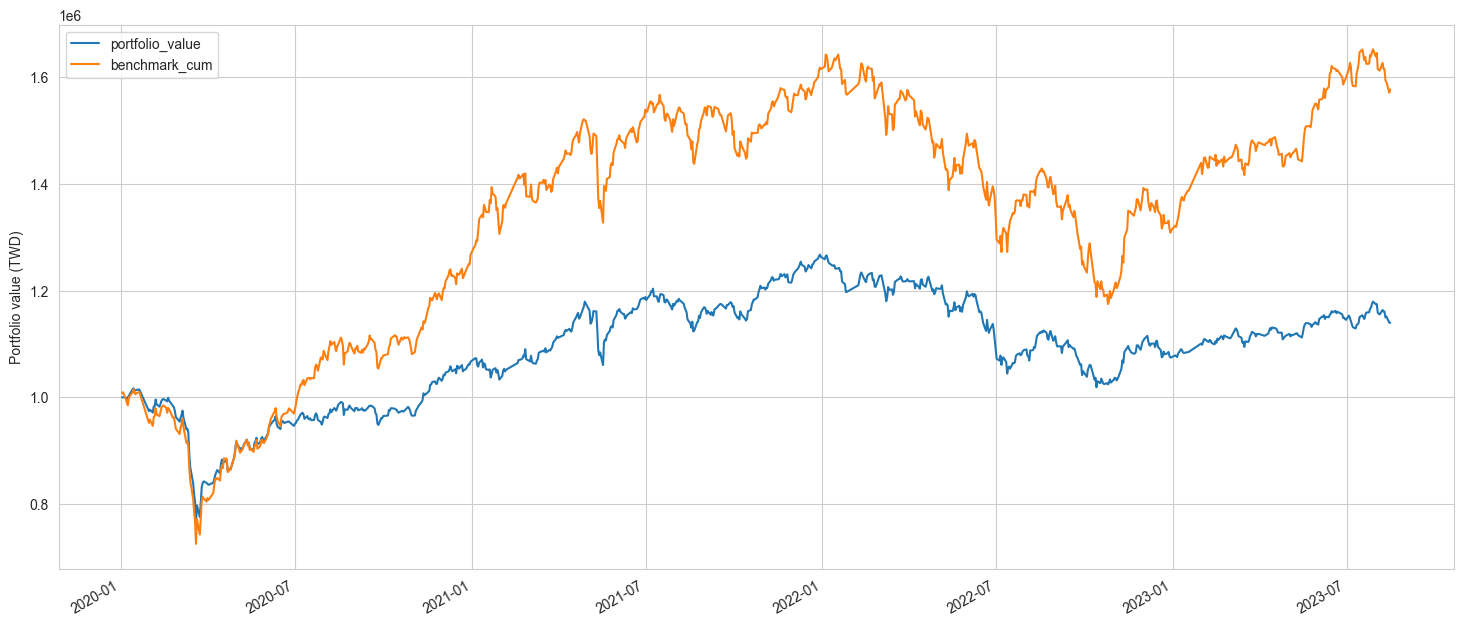

In [13]:
start_dt = pd.Timestamp('2020-01-01', tz='utc')
end_dt = pd.Timestamp('2023-08-15', tz='utc')

Bindex=get_Benchmark_Return(start=start_dt,
                     end=end_dt,
                     symbol='IR0001').sort_index(ascending=True).tz_convert('utc')

results = run_algorithm(start=start_dt, 
                       end=end_dt,
                       initialize=initialize,
                       before_trading_start=before_trading_start,
                       capital_base=1e6,
                       benchmark_returns=Bindex,
                       data_frequency='daily',
                       bundle='tquant',
                       custom_loader=transform_data,
                       analyze=portfolio_plot) 

### Pyfolio－投組績效分析

In [14]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

perf_stats = show_perf_stats(returns=returns,
                factor_returns=results.benchmark_return,
                positions=positions,
                transactions=transactions,
                live_start_date='2023-01-01')

Start date,2020-01-02
End date,2023-08-15
Total months,41
,Backtest
Annual return,3.822%
Cumulative returns,13.977%
Annual volatility,12.705%
Sharpe ratio,0.36
Calmar ratio,0.15
Stability,0.38
Max drawdown,-24.93%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.93,2020-01-14,2020-03-19,2020-11-18,206
1,19.60,2021-12-29,2022-10-13,NaT,NaN
2,10.08,2021-04-28,2021-05-17,2021-06-25,41
3,6.65,2021-07-08,2021-08-19,2021-10-28,78
4,3.75,2021-01-04,2021-01-29,2021-02-23,30


Stress Events,mean,min,max
New Normal,0.02%,-5.15%,4.45%


Top 10 long positions of all time,max
sid,
3481,5.63%
2448,5.11%
1722,4.96%
2492,4.93%
2201,4.93%
1605,4.08%
3008,4.07%
2498,4.04%
2409,3.93%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
3481,5.63%
2448,5.11%
1722,4.96%
2492,4.93%
2201,4.93%
1605,4.08%
3008,4.07%
2498,4.04%
2409,3.93%


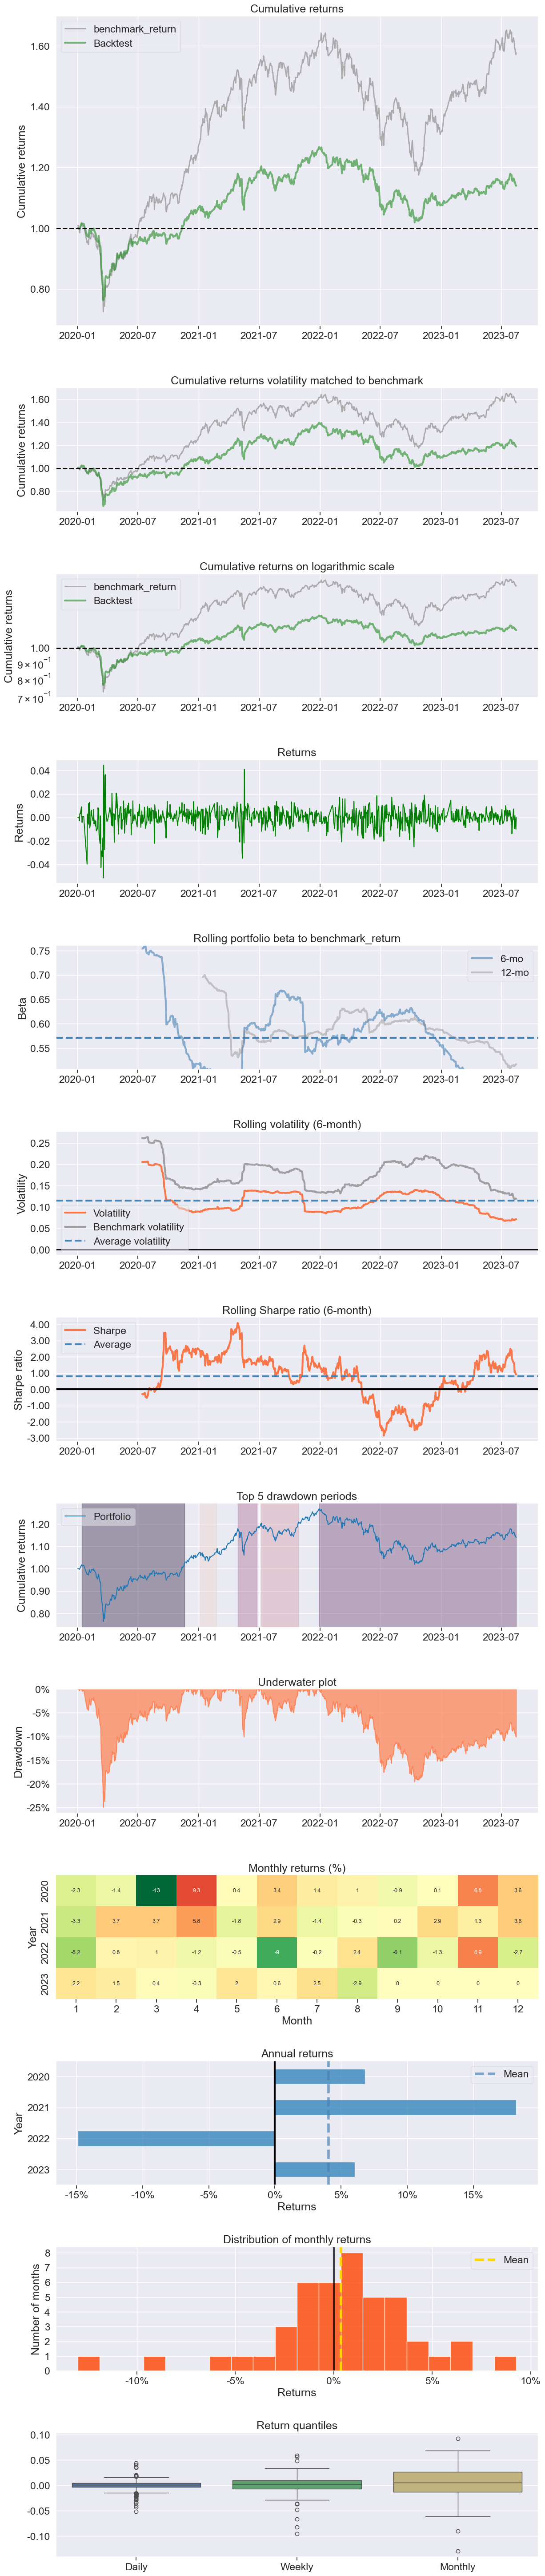

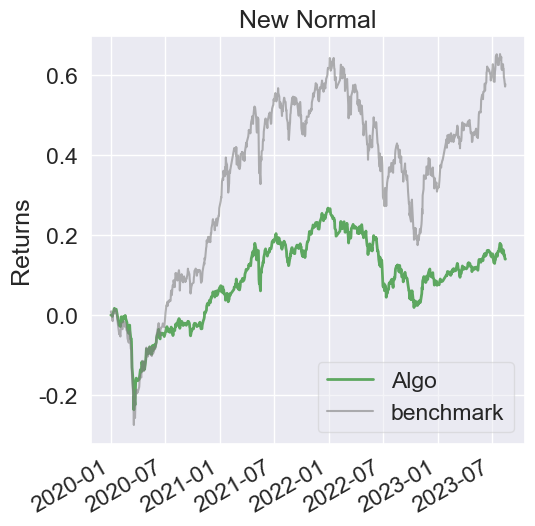

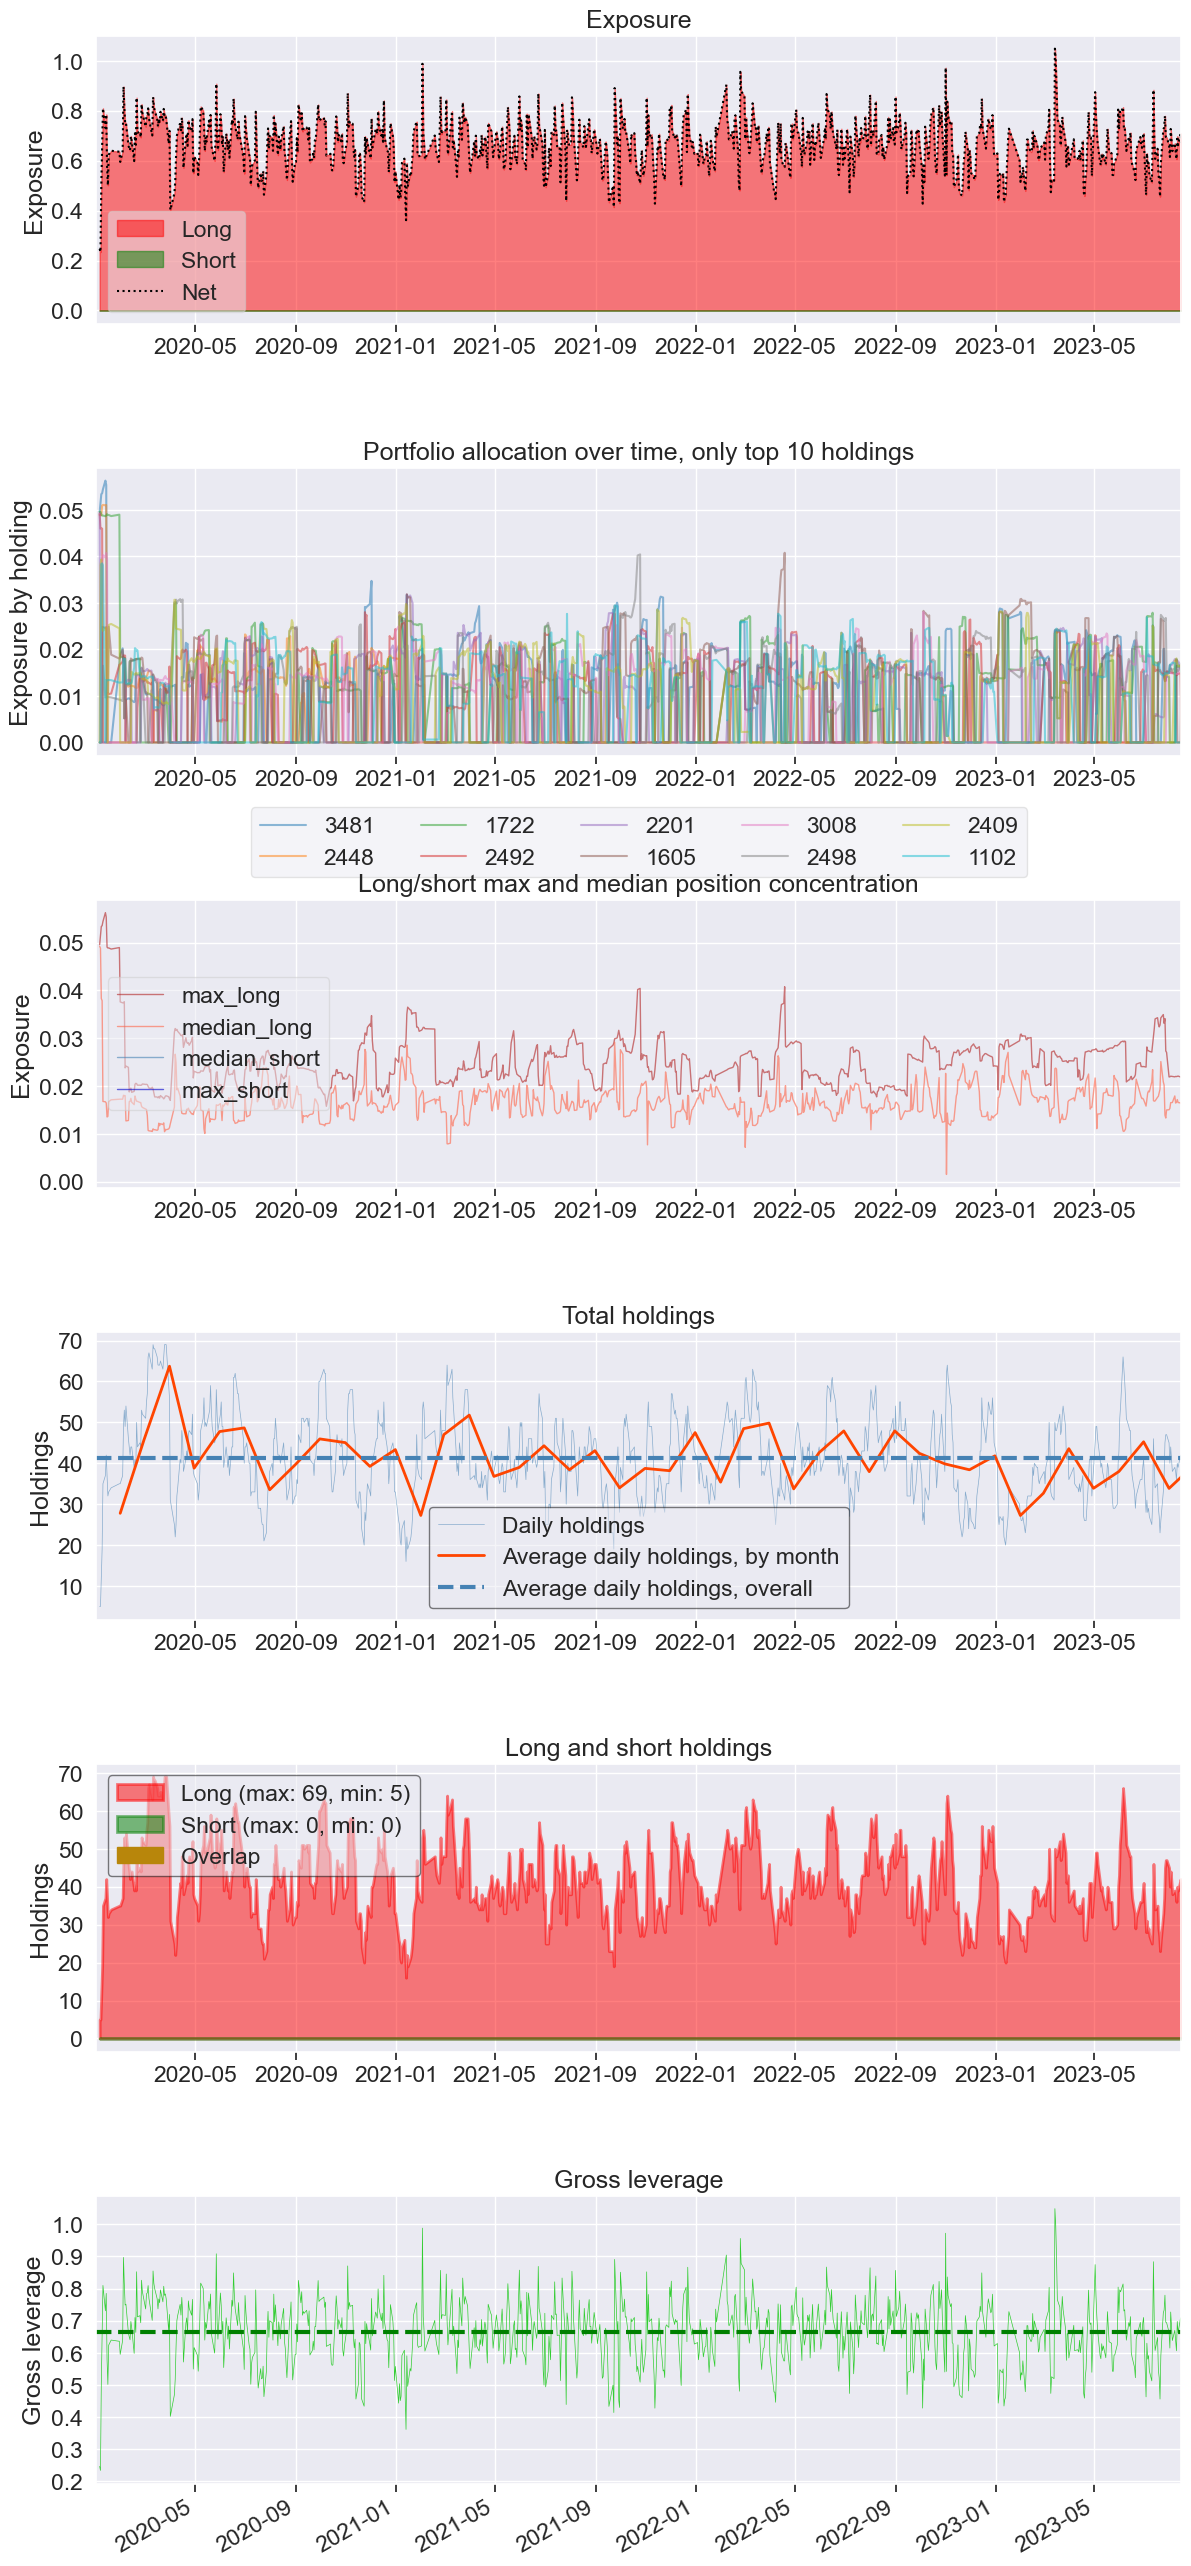

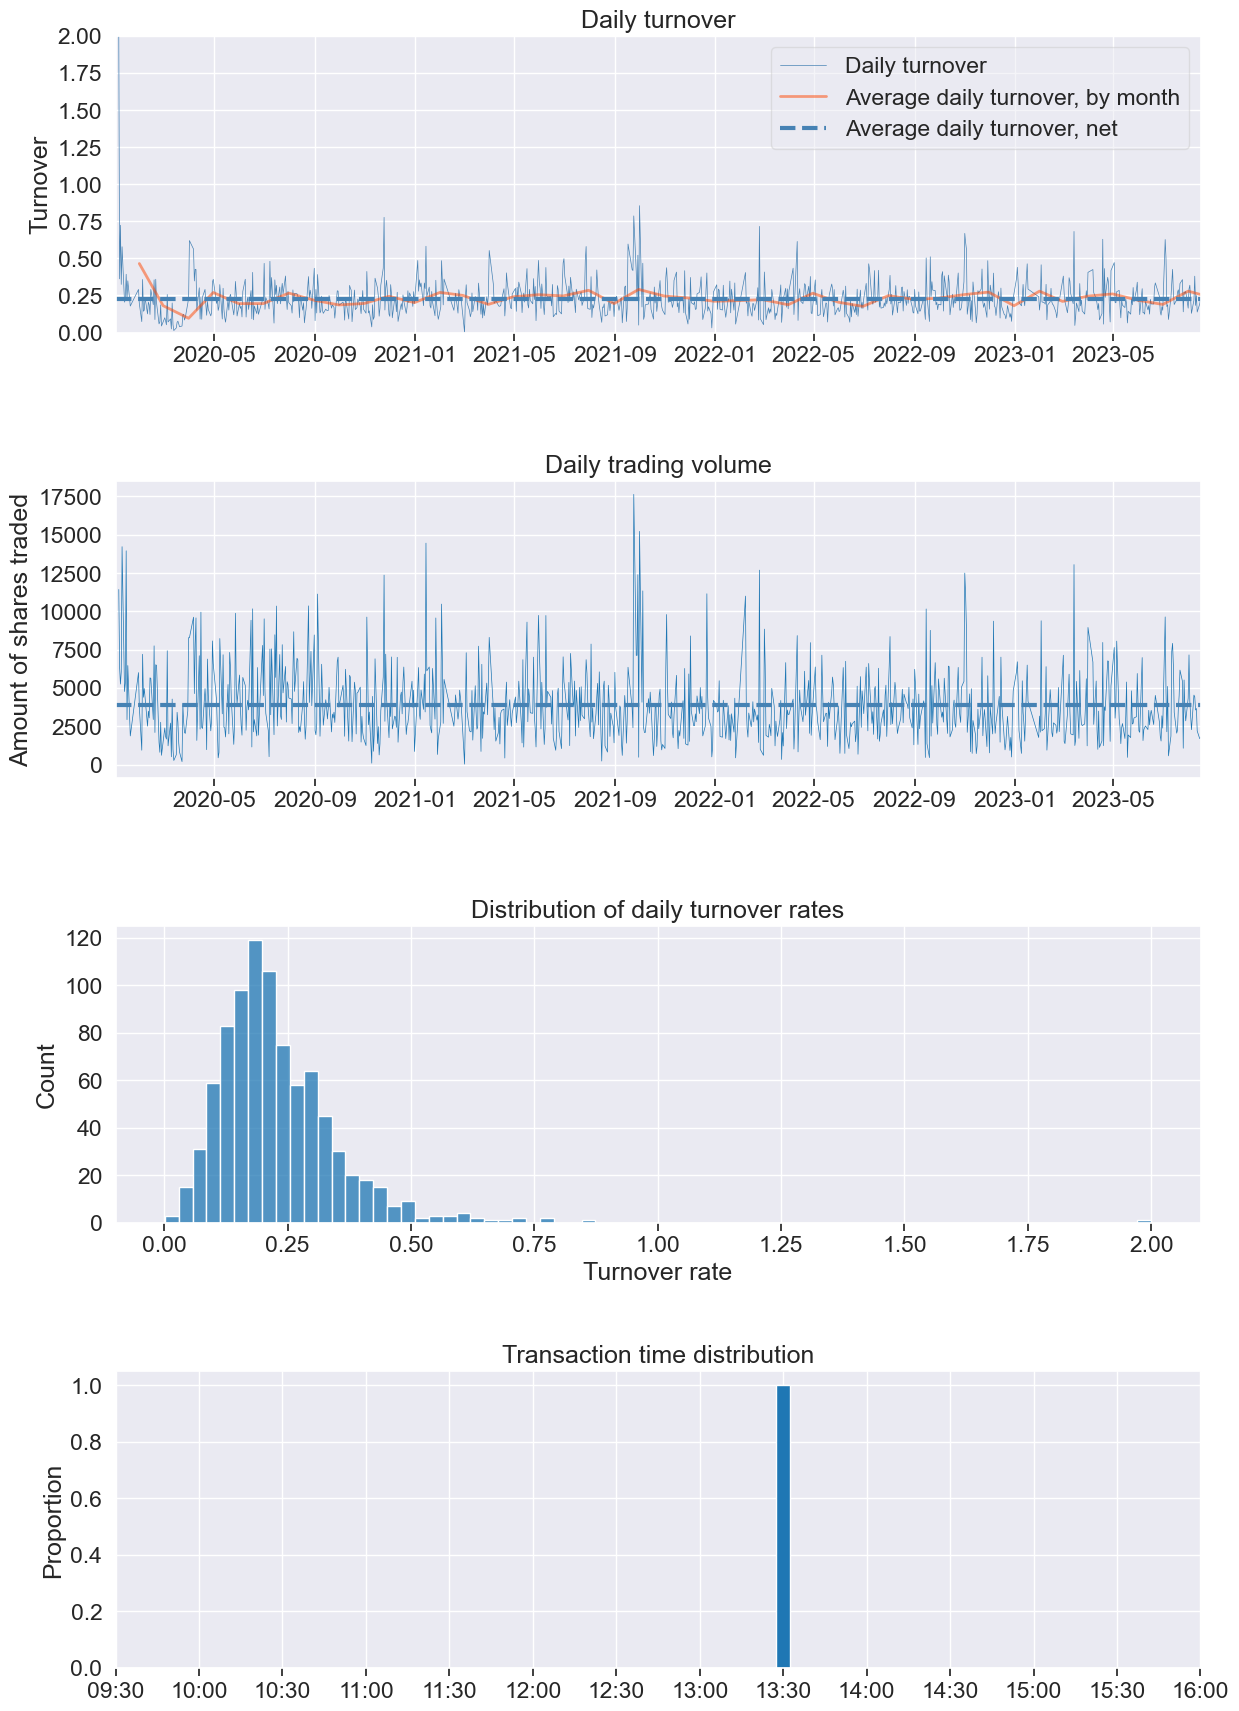

In [15]:
import pyfolio as pf
returns.index = returns.index.tz_localize(None).tz_localize('UTC')
positions.index = positions.index.tz_localize(None).tz_localize('UTC')
transactions.index = transactions.index.tz_localize(None).tz_localize('UTC')
results.benchmark_return.index = results.benchmark_return.index.tz_localize(None).tz_localize('UTC')

pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=results.benchmark_return)